- Capture definitions, connection with MMCore
- Take sample image, train clf and stardist on it
- test create light-mask logic
- Loop

## import all the stuff

In [1]:
#from csbdeep.io import save_tiff_imagej_compatible
#from __future__ import print_function, unicode_literals, absolute_import, division

#60x oil: Z=3633
# Import packages
import cv2
import gc
import importlib.util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import queue
import math

import skimage #pip install scikit-image==0.18.2rc1
import threading
import time

from csbdeep.utils import Path, normalize
from glob import glob
from importlib import reload 
from multiprocessing import Process
from pycromanager import Bridge
from skimage import io
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from tqdm import tqdm

# Import own code
from manager.stage import load_pos_file, get_pos_from_mm, stage_position
from manager.acquisition import acq, acq_stim, acq_multi, acq_multi_dark, acq_mask
from manager.fov import FOV
from manager.dmd import dmd
from manager.preset import preset
from manager.stage import load_pos_file, get_pos_from_mm
from pipeline.pipeline_single_frame import add_frame
from pipeline.stimulation import stim_random
from utils import create_folders

matplotlib.rcParams["image.interpolation"] = None
%matplotlib inline
#%matplotlib notebook




#### pixel clf imports
from semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import time
from skimage import io
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import pickle
import glob
import time
from PIL import Image
import cv2
from skimage.color import label2rgb
import os
from csbdeep.utils import Path, normalize
from skimage.measure import regionprops_table
import pandas as pd
from skimage.segmentation import expand_labels
import napari
import numpy as np 
from napari.layers import Image, Labels
from magicgui import magicgui
from semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from sklearn.ensemble import RandomForestClassifier
import scipy
import skimage
from skimage.morphology import square
import pickle as pkl
import nest_asyncio
import threading
from csbdeep.utils import Path, normalize

from magicgui import magicgui
from magicgui.widgets import Label, SpinBox, PushButton, Text, Container

from multiprocessing import Process
from napari.layers import Image, Labels
from napari.qt import thread_worker

import nest_asyncio

import queue


matplotlib.rcParams["image.interpolation"] = None
nest_asyncio.apply()
nest_asyncio.apply()

%gui qt
%matplotlib inline
from PIL import Image
from csbdeep.utils import Path, normalize
from glob import glob
from importlib import reload 
from magicgui import magicgui
from magicgui.widgets import Label, SpinBox, PushButton, Text, Container
from manager.acquisition import acq, acq_stim, acq_multi, acq_multi_dark, acq_mask
from manager.dmd import dmd
from manager.fov import FOV
from manager.preset import preset
from manager.stage import load_pos_file, get_pos_from_mm, stage_position
from matplotlib import pyplot as plt 
from multiprocessing import Process
from napari.layers import Image, Labels
from napari.qt import thread_worker
from pipeline.pipeline_single_frame import add_frame
from pipeline.stimulation import stim_random
from pycromanager import Acquisition, multi_d_acquisition_events
from pycromanager import Bridge
from semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from skimage import io
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.morphology import square
from skimage.segmentation import expand_labels
from sklearn.ensemble import RandomForestClassifier
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from tqdm import tqdm
from utils import create_folders
import cv2
import gc
import glob
import importlib.util
import math
import matplotlib
import matplotlib.pyplot as plt
import napari
import nest_asyncio
import numpy as np
import os
import pandas as pd
import pickle as pkl
import queue
import scipy
import skimage
import threading
import time
import trackpy as tp
matplotlib.rcParams["image.interpolation"] = None


## Setup connection with micro manager

In [2]:
bridge = Bridge() #connection to micro-manager
core = bridge.get_core()
studio = bridge.get_studio()
print(bridge.get_core())
dmd = dmd(core) #init dmd device

## Set up basic microscope config (light path, hardware triggering, binning etc)

In [3]:
nidaq_setup = preset(core) #focus preset
nidaq_setup.settings = [

    ["Spectra RIGHT","Teal_Level",100],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Level",100],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Level",100],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Level",100],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Level",100],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Level",100],
    ["Spectra RIGHT","Red_Enable",0],

    ["Spectra RIGHT","White_Enable",0],
    ['Andor sCMOS LEFT','AuxiliaryOutSource (TTL I/O)','FireAny']
]
nidaq_setup.apply_no_retry()

camera_setup = preset(core) #focus preset
camera_setup.settings = [
    ["Andor sCMOS LEFT","Binning",'2x2'],
    #["Andor sCMOS LEFT","Sensitivity/DynamicRange",'12-bit (low noise)'],
    #["Andor sCMOS LEFT","Exposure",'300'],
    #["Andor sCMOS LEFT","TriggerMode",'Software (Recommended for Live Mode)'],
    ["TILightPath","State",'2'],
    ["Mosaic3","TriggerMode",'InternalExpose'], #InternalSoftware
    #["Andor sCMOS LEFT","PixelReadoutRate",'200 MHz - lowest noise'],
]

camera_setup.apply(core)

Andor sCMOS LEFT: Set Binning to 2x2
TILightPath: Set State to 2
Mosaic3: Set TriggerMode to InternalExpose


## Load some test data to if the spot-drawing function works

In [4]:
project_path = 'Z:\\lhinder\\data\\rtm_mm_data\\exp_51\\'
fov = 0
file_name_pattern = str(fov).zfill(2)+"_*.tiff"

print(file_name_pattern)
filenames = sorted(glob.glob(project_path + os.path.join("raw",file_name_pattern)))
print(filenames[-1])
raw = io.imread(filenames[-1])
raw = raw[:,400:850,150:700]

print(file_name_pattern)
filenames = sorted(glob.glob(project_path + os.path.join("mask",file_name_pattern)))
print(filenames[-1])
labels = io.imread(filenames[-1])
labels = io.imread(filenames[-1])
labels = labels[400:850,150:700]
labels = skimage.morphology.remove_small_objects(labels, min_size=100**2)

00_*.tiff
Z:\lhinder\data\rtm_mm_data\exp_51\raw\00_01549.tiff
00_*.tiff
Z:\lhinder\data\rtm_mm_data\exp_51\mask\00_01549.tiff


## define the spot drawing function and run it on the test data

(34, 61, 233, 150)
(281, 270, 416, 483)


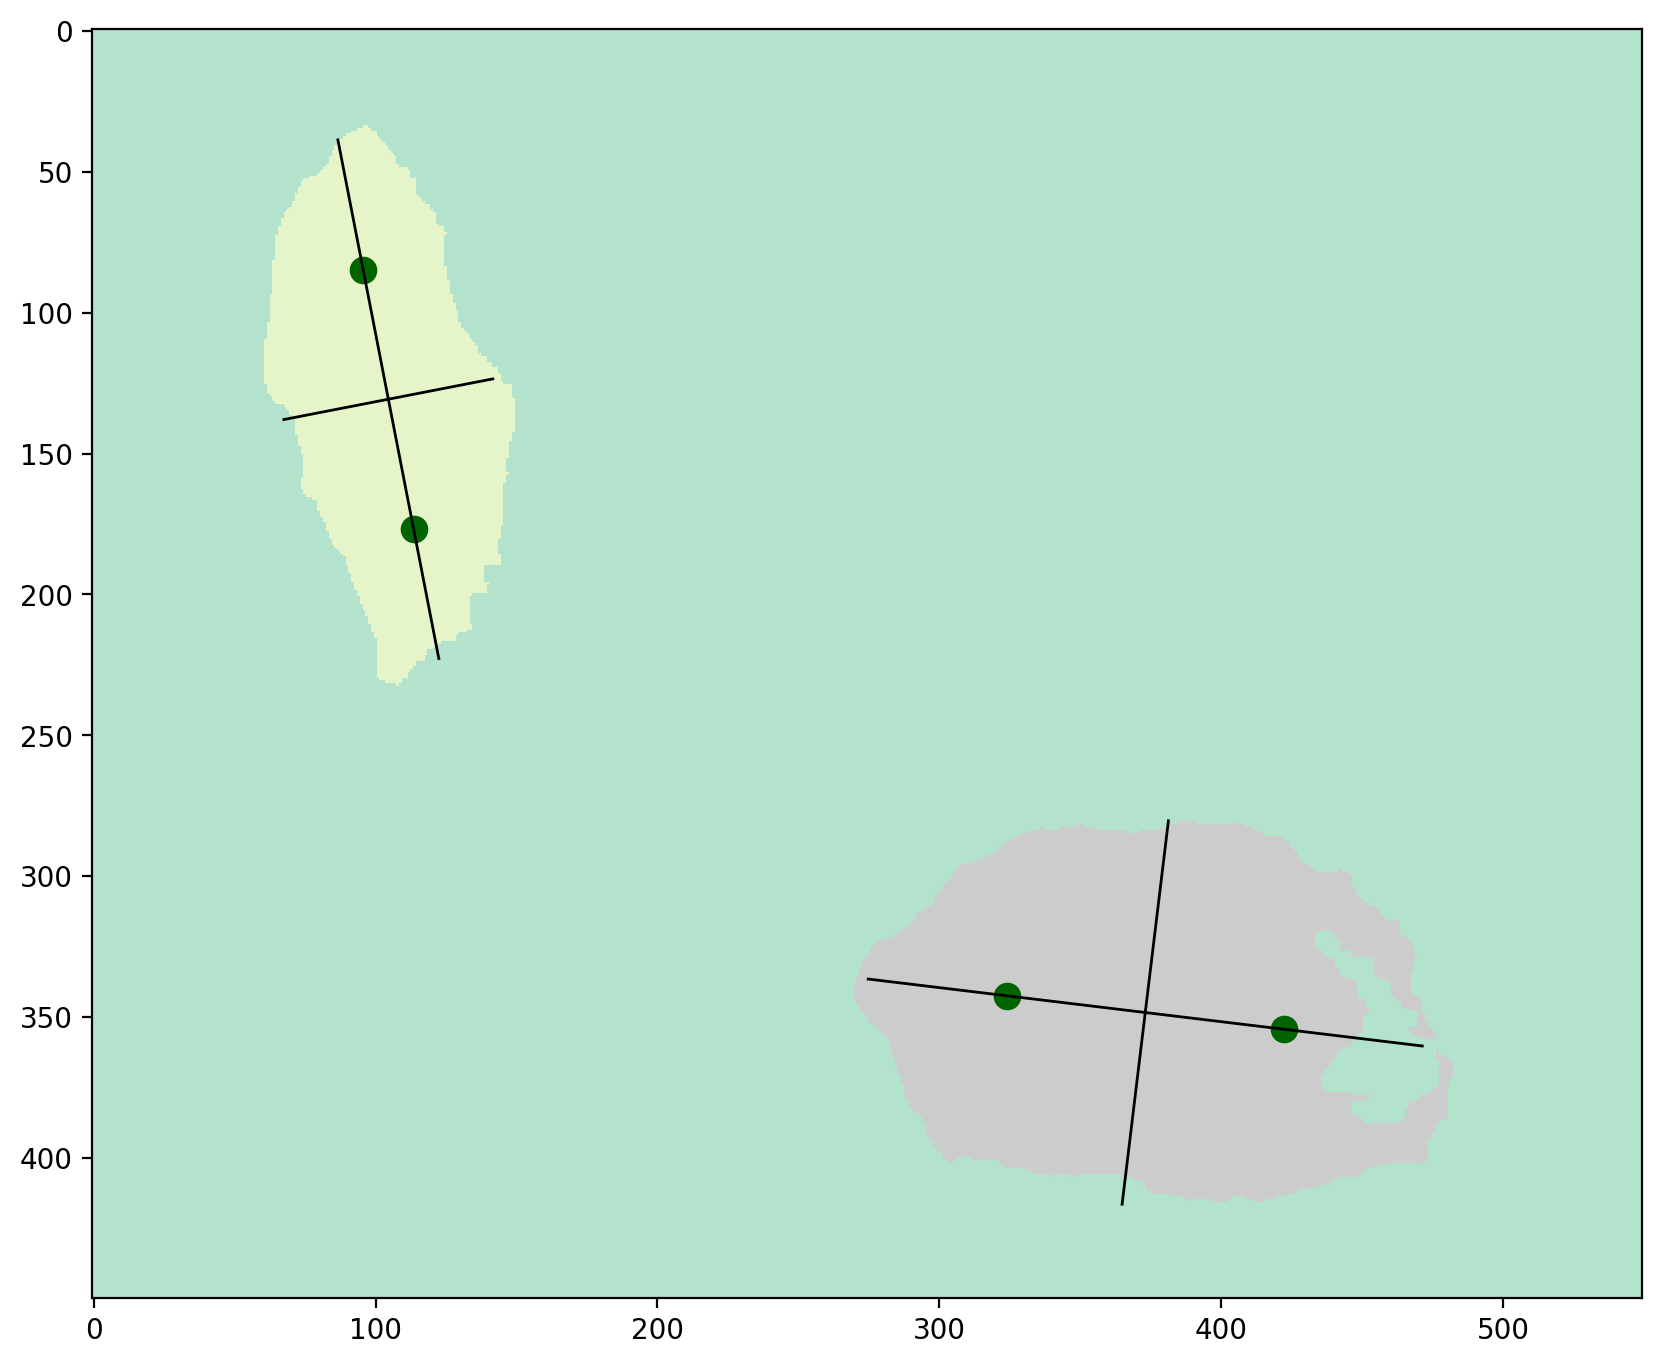

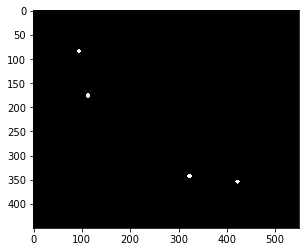

cell_label      cell_x      cell_y  cell_area  spot_radius      spot_x  \
0          16  104.545580  130.732959      10871            5   95.594052   
0          16  104.545580  130.732959      10871            5  113.497108   
0          18  373.122082  348.354651      20265            5  323.980746   
0          18  373.122082  348.354651      20265            5  422.263419   

       spot_y  
0   84.729173  
0  176.736746  
0  342.417562  
0  354.291740

In [5]:

def centroid(p0,p1,p2):
    a = 0.35 #centroid
    b = 1 #extent
    x = (a*p0[0]+b*p1[0]+b*p2[0])/(a+2*b)
    y = (a*p0[1]+b*p1[1]+b*p2[1])/(a+2*b)
    return x,y

def middle(p0,p1):
    a = 1#centroid
    b = 1 #extent
    x = (a*p0[0]+b*p1[0])/(2)
    y = (a*p0[1]+b*p1[1])/(2)
    return x,y

def draw_circle(xy, size, spot_mask):
    '''Takes a list of coordinates [(y,x),(y,x),...] and draws an ellipse on a mask for every point. '''
    #Elipse properties
    axesLength = (size,size) #20, 5 for horizontally stretched ellipse 
    angle = 0
    startAngle = 0
    endAngle = 360
    color = (1) 
    thickness = -1

    center_coordinates = (int(xy[0]),int(xy[1]))
    spot_mask = cv2.ellipse(spot_mask, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness) 
    return spot_mask


def spot_mask_from_labels(labels):
    '''Creates four spots for every cell in a segmentation image. Returns a binary image for the DMD.
    Returns a datatable that contains data for every spot: Cell label, cell size, cell centroid, spot centroid, spot size.'''
    df = pd.DataFrame()
    props = skimage.measure.regionprops(labels)

    plt.figure(figsize = (10,10),dpi = 200)
    plt.imshow(labels%13,cmap = 'Pastel2')

    an_size = 40
    cutouts = []
    
    spot_mask = np.zeros_like(labels)

    for prop in props[:]:
        print(prop.bbox)
        bbox = prop.bbox
        bbox_top = bbox[0]
        bbox_left = bbox[1]

        bbox_bottom = bbox[2]
        bbox_right = bbox[3]

        y = prop.centroid[0]
        x = prop.centroid[1]

        stim_top_x = (x+x)/2
        stim_top_y = (bbox_top +y)/2

        stim_right_y = (y+y)/2
        stim_right_x = (bbox_right+x)/2

        stim_bottom_x = (x+x)/2
        stim_bottom_y = (y+bbox_bottom)/2

        stim_left_x = (x+bbox_left)/2
        stim_left_y = (y+y)/2

        ax = plt.gca()

        x0 = x
        y0 = y
        
        orientation = prop.orientation

        x1 = x0 + math.cos(orientation) * 0.5 * prop.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * prop.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * prop.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * prop.major_axis_length


        minr, minc, maxr, maxc = prop.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)


        x3 = x0 - math.cos(orientation) * 0.5 * prop.minor_axis_length
        y3 = y0 + math.sin(orientation) * 0.5 * prop.minor_axis_length
        x4 = x0 + math.sin(orientation) * 0.5 * prop.major_axis_length
        y4 = y0 + math.cos(orientation) * 0.5 * prop.major_axis_length



        minr, minc, maxr, maxc = prop.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)

        x5,y5 = middle((x0,y0),(x2,y2))
        plt.scatter(x5,y5, c = 'darkgreen',s = 80)
        spot_mask = draw_circle((x5,y5),4,spot_mask)
        df_spot = pd.DataFrame({'cell_label': [prop.label],'cell_x': [x], 'cell_y': [y], 'cell_area': [prop.area],'spot_radius': [5], 'spot_x': [x5], 'spot_y': [y5]})
        df = df.append(df_spot)
        
        x5,y5 = middle((x4,y4),(x0,y0))
        plt.scatter(x5,y5, c = 'darkgreen',s = 80)
        spot_mask = draw_circle((x5,y5),4,spot_mask)
        df_spot = pd.DataFrame({'cell_label': [prop.label],'cell_x': [x], 'cell_y': [y], 'cell_area': [prop.area],'spot_radius': [5], 'spot_x': [x5], 'spot_y': [y5]})
        df = df.append(df_spot)
        
        ax.plot((x0, x3), (y0, y3), '-k', linewidth=1.)
        ax.plot((x0, x4), (y0, y4), '-k', linewidth=1.)
        ax.plot((x0, x1), (y0, y1), '-k', linewidth=1.)
        ax.plot((x0, x2), (y0, y2), '-k', linewidth=1.)

        
    plt.show()
    return spot_mask.astype('uint8'), df

spot_mask,df = spot_mask_from_labels(labels)
plt.imshow(spot_mask, cmap = 'gray')
plt.show()
df

In [6]:
from scipy import ndimage
from skimage.morphology import binary_erosion

def spot_mask_from_labels(labels):
    '''takes label mask, shrinks objects and subtracts from original image.'''
    stim_width = 10
    footprint = np.ones((stim_width,stim_width))
    labels_b = labels>0
    labels_b_ero = binary_erosion(labels_b,footprint)
    labels_b_sub = np.logical_xor(labels_b,labels_b_ero)
    labels_b_sub = labels_b_sub.astype('uint8')
    labels_sub = np.multiply(labels_b_sub,labels)
    
    df = pd.DataFrame()
    props = skimage.measure.regionprops(labels)
    for prop in props[:]:
        df_spot = pd.DataFrame({'cell_label': [prop.label],'cell_x': [prop.centroid[0]], 'cell_y':[prop.centroid[1]], 'cell_area': [prop.area],'stim_width':[stim_width]})
        df = df.append(df_spot)

    return labels_b_sub,df

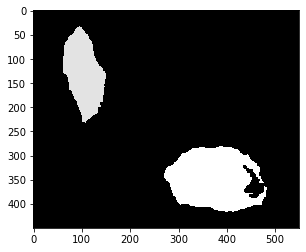

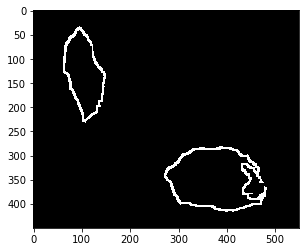

cell_label      cell_x      cell_y  cell_area  stim_width
0          16  130.732959  104.545580      10871          10
0          18  348.354651  373.122082      20265          10

In [7]:
spot_mask,df = spot_mask_from_labels(labels)
plt.imshow(labels, cmap = 'gray')
plt.show()
plt.imshow(spot_mask, cmap = 'gray')
plt.show()
df

### mCherrychannel (green laser)

In [8]:
ERK_capture = preset(core)
# 555/25 with same filterwheel as H2B or 575 with 2/2
ERK_capture.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "1"],#2 
    ["Wheel-C", "State", 1],# could also use 1 # standard  2
    ["Spectra RIGHT","Green_Enable",1],
    ["Spectra RIGHT","Green_Level",25] #25
]
ERK_capture.camera_exposure_time = 100 #150
ERK_capture.dmd_exposure_time = 100
ERK_capture.name = "ERK"

ERK_capture.apply(core)
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 1
Spectra RIGHT: Set Green_Enable to 1
Spectra RIGHT: Set Green_Level to 25


## Paxillin channel (red laser)

In [9]:
H2B_capture = preset(core)
#IRFP
H2B_capture.settings = [ # Actin used for segmentation
    ["TIFilterBlock1", "State", "1"],
    ["Wheel-C", "State", 1],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",1],
    ["Spectra RIGHT","Red_Level",50] #75
    
]
H2B_capture.camera_exposure_time = 200 #500
H2B_capture.dmd_exposure_time = 200
H2B_capture.name = "H2B"
H2B_capture.apply()
dmd.all_on()
#dmd.checker_board()


In [10]:
dmd.checker_board()


In [11]:
dmd.all_off()

## Check the expression of the opto

In [12]:
#CHECK EXPRESSION OF OPTOGENETIC CONSTRUCT
OPTO_capture = preset(core) #mCitrine
OPTO_capture.settings = [
    ["Spectra RIGHT","Teal_Enable",1], 
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["TIFilterBlock1", "State", "5"],#2
    ["Wheel-C", "State", 4],#4 #1 #2
    ["Spectra RIGHT","White_Level",0],
    ["Spectra RIGHT","Cyan_Enable",0], #should be cyan instead of TEAL which worked tho [green, ti=3, cw=1 \\ cyan ti=2,cw=1]
    ["Spectra RIGHT","Teal_Level",10]
]
OPTO_capture.camera_exposure_time = 100 #100ms for 40x 
OPTO_capture.dmd_exposure_time = 100
OPTO_capture.name = "OPTO_capture"
OPTO_capture.apply(core)
#dmd.checker_board()
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 1
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 5
Wheel-C: Set State to 4
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Teal_Level to 10


## Channel used to stim opto and calibrate the dmd

In [13]:
OPTO_cal = preset(core) #Cyan
OPTO_cal.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "2"],#2
    ["Wheel-C", "State", 0],#4 #1 #2
    ["Spectra RIGHT","White_Level",0],
    ["Spectra RIGHT","Cyan_Enable",1], #should be cyan instead of TEAL which worked tho [green, ti=3, cw=1 \\ cyan ti=2,cw=1]
    ["Spectra RIGHT","Cyan_Level",10] ## DONT GO LOWER THAN 6! Else output will be 0
]
OPTO_cal.camera_exposure_time = 50 #100ms for 40x 
OPTO_cal.dmd_exposure_time = 60
OPTO_cal.name = "OPTO_cal"
OPTO_cal.apply(core)
#dmd.checker_board()
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 2
Wheel-C: Set State to 0
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 10


## Turn off all lights

In [14]:
black = preset(core)
black.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["Wheel-C", "State", 0],
]
black.apply()

### Add all channels to the list that should show up in interface

In [15]:
channels = [H2B_capture,ERK_capture,OPTO_capture,OPTO_cal,black]

## NAPARI LIVE VIEW

### Settings (running this deletes all positions)

In [16]:
# data acquired on microscope or simulated?
simulate = False
clip =[1024, 1024]
# um / px, for correct scaling in napari
size_um = [0.16, 0.16]
#Time between checking again if new image is available
sleep_time = 0.05
# contrast limits for display
clim = [0, 300]
# initialize global variables
# flag to break while loops
acq_running = False
# empty queue for image data and z positions
img_queue = queue.Queue()
# xyz data stack
data = np.random.rand(clip[0], clip[1]) * clim[1]
zmq_lock = threading.Lock()
position_list = []

### Open napari live-view

In [17]:
import cv2
font = cv2.FONT_HERSHEY_DUPLEX
checker_board = np.kron([[1, 0] * 20, [0, 1] * 20] * 20, np.ones((20, 20))) #https://stackoverflow.com/a/37440123
startup_screen = checker_board*100
cv2.putText(startup_screen,'github.com/hinderling',(40,780), font, 2,(255),2)
#plt.imshow(startup_screen)
data = startup_screen

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    zmq_lock.release()
    if remaining_image_count < 1:
        #print('No image in uManager queue.')
        time.sleep(0.5)
        return
    
    zmq_lock.acquire()
    array = core.get_last_image()
    #core.clear_circular_buffer()
    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[:,:]
    img_queue.put([channels[1], img])
    return

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    if remaining_image_count < 1:
        zmq_lock.release()
        #print('Warning: No image in uManager queue.')
        time.sleep(0.5)
        return
    try:
        array = core.get_last_image()
    except:
       # print('ERROR: No image in uManager queue.')
        time.sleep(0.5)
        return

    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[::2,::2]
    img_queue.put([channels[1], img])
    return

def display_napari(image):
    """ Unpacks z position and reshapes image from pos_img. Writes image into correct
        slice of data, and updates napari display.
        Called by worker thread yielding elements from queue.
        Needs to be in code before worker thread connecting to it.
        Inputs: array pos_img: queue element containing z position and raveled image data.
        Global variables: np.array data: contains image stack
            img_queue: needed only to send task_done() signal.
    """
    global data
    global img_queue
    channel = image[0]
    image= image[1]
    layers[0].data = image
    img_queue.task_done()

@thread_worker
def append_img(img_queue):
    """ Worker thread that adds images to a list.
        Calls either micro-manager data acquisition or functions for simulating data.
        Inputs: img_queue """

    # start microscope data acquisition
    #print('Worker started: append_img')
    if not simulate:
         while acq_running:
            acquire_data()
            time.sleep(sleep_time)

    # run with simulated data
    else:
        ii = 0
        while acq_running:
            simulate_data(ii)
            ii = ii + 1
            #print("appending to queue", ii)
            time.sleep(sleep_time)


@thread_worker(connect={'yielded': display_napari})
def yield_img(img_queue):
    """ Worker thread that checks whether there are elements in the
        queue, reads them out.
        Connected to display_napari function to update display """
   # print('Worker started: yield_img')
    global acq_running
    
    #time_last_frame = time.time()
    #print('yield image')
    
    #print(acq_running)
    while acq_running:
        #time.sleep(sleep_time)
        # get elements from queue while there is more than one element
        # playing it safe: I'm always leaving one element in the queue
        img_queue_size = img_queue.qsize()
        #print(img_queue_size)
        while img_queue.qsize() > 0:
           # print("reading from queue ", img_queue.qsize())
            yield img_queue.get(block = False)
            #time_this_frame = time.time()
            #time_diff = time_this_frame - time_last_frame
            #fps = int(1/time_diff)
        time.sleep(sleep_time)

    # read out last remaining elements after end of acquisition
    while img_queue.qsize() > 0:
        yield img_queue.get(block = False)
   # print("acquisition done")
@magicgui(call_button = "Start")
def start_acq():
    """ Called when Start button in pressed. Starts workers and resets global variables"""
    #print("starting threads...")
    global acq_running
    global channels
    global zmq_lock
    if not acq_running:
        #z_range[3] = 0
        acq_running = True
        zmq_lock.acquire()
        core.start_continuous_sequence_acquisition(0)
        zmq_lock.release()
        worker1 = append_img(img_queue)
        worker2 = yield_img(img_queue)
        worker1.start()
        #worker2.start() # doesn't need to be started bc yield is connected
    else:
        print("acquisition already running!")

threshold = 100

@magicgui(slider_float={"widget_type": "FloatSlider", 'max': 1000})
def set_treshold(slider_float=100):
    global threshold
    threshold = slider_float

@magicgui(call_button = "Stop")
def stop_acq():
    #print("stopping threads")
    # set global acq_running to False to stop other workers
    global acq_running
    global core
    global zmq_lock
    
    zmq_lock.acquire()
    core.stop_sequence_acquisition()    
    zmq_lock.release()
    acq_running = False

    
#a channel is a preset that has EXPOSURE and POWER function
channels_widget = Container()
channels_widgets_list = []
for channel in channels:
    @magicgui(
    call_button = 'SELECT',
    auto_call=False,
    label = {"widget_type": "Label","name":"label","label":channel.name},
    power={"widget_type": "SpinBox","name":"power" ,"label":'%',"min":0,"max": 100},
    exposure={"widget_type": "SpinBox","name":"ms" ,"label":'ms',"min":1,"max": 10000},
    #mode={"choices": ["reflect", "constant", "nearest", "mirror", "wrap"]},
    layout='horizontal',
    channel={'bind': channel} #replace this with channel 
    )
    def channel(label, power: int = channel.settings[-1][2], exposure=channel.camera_exposure_time, channel = channel):
        global channels
        #print(channel.name)
        stop_acq()
        channel.camera_exposure_time = exposure
        channel.set_power(power)
        zmq_lock.acquire()
        channel.apply()
        dmd.all_on()
        zmq_lock.release()
        start_acq()
    channels_widgets_list.append(channel)

channels_widget = Container(widgets=(channels_widgets_list))
        
@magicgui(call_button = "Store position")
def store_pos():
    global channels
    global zmq_lock
    global acq_running
    global position_list
    restart = False
    if acq_running:
        stop_acq()
        restart = True
    zmq_lock.acquire()
    point = core.get_xy_stage_position()
    pfs_offset = core.get_auto_focus_offset()
    x = point.get_x()
    y = point.get_y()
    zmq_lock.release()
    position_list.append(stage_position(x,y,pfs_offset))
    if restart:
        start_acq()    
        
# check if viewer is already open
# if yes: close and reopen
try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
viewer = napari.Viewer(ndisplay=2)

# initialize napari viewer with stack view and random data, reslice view
#scale = [(z_range[1]-z_range[0])/z_range[2]*z_scale, size_um[1], size_um[0]]
layers = [viewer.add_image(data,
                        name = 'zero',
                        colormap = 'gray',
                        interpolation = 'nearest',
                        blending = 'additive',
                        rendering = 'attenuated_mip',
                        #scale = scale,
                        contrast_limits = clim)
         ]

#viewer.dims._roll()
viewer.window.add_dock_widget(start_acq,area='left')
viewer.window.add_dock_widget(stop_acq,area='left')
viewer.window.add_dock_widget(channels_widget,area='left') 
viewer.window.add_dock_widget(store_pos,area='left')
viewer.text_overlay.visible = True
#viewer.window.qt_viewer.canvas.measure_fps(callback=update_fps)    

viewer already closed or never opened


In [18]:
break

SyntaxError: 'break' outside loop (<ipython-input-18-6aaf1f276005>, line 1)

## Import the positions from MM and show a preview

In [109]:
#position_list = get_pos_from_mm(studio)

In [94]:
#Store List
with open('F:\\Max\\STAR\\STAR_40\\positions\\pos_list_31.pkl', "wb") as fp:   #Pickling
    pickle.dump(position_list, fp)
    
    

In [19]:
#Load List
with open('F:\\Max\\STAR\\STAR_40\\positions\\pos_list_31.pkl', "rb") as fp:   #Pickling
    position_list = pickle.load(fp)

22


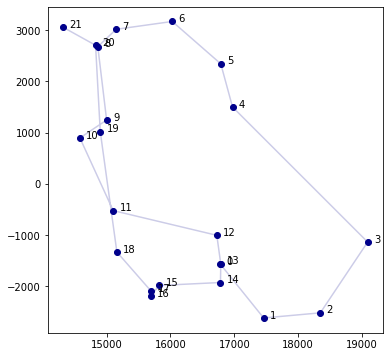

In [20]:
# preview positions
xs = []
ys = []
plt.figure(figsize= (6,6))
for i,pos in enumerate(position_list):
    plt.scatter(pos.x,pos.y,c ='darkblue')
    xs.append(pos.x)
    ys.append(pos.y)
    plt.text(pos.x+100, pos.y, str(i))
print(len(position_list))
plt.plot(xs,ys,c = 'darkblue',alpha = 0.2)
plt.show()

## Load affine transformation matrix from disk

the last one worked well so just load it from file (`affine_60x_2bin_CYAN.npy`)

### Do a new calibration:

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 2
Wheel-C: Set State to 0
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 10


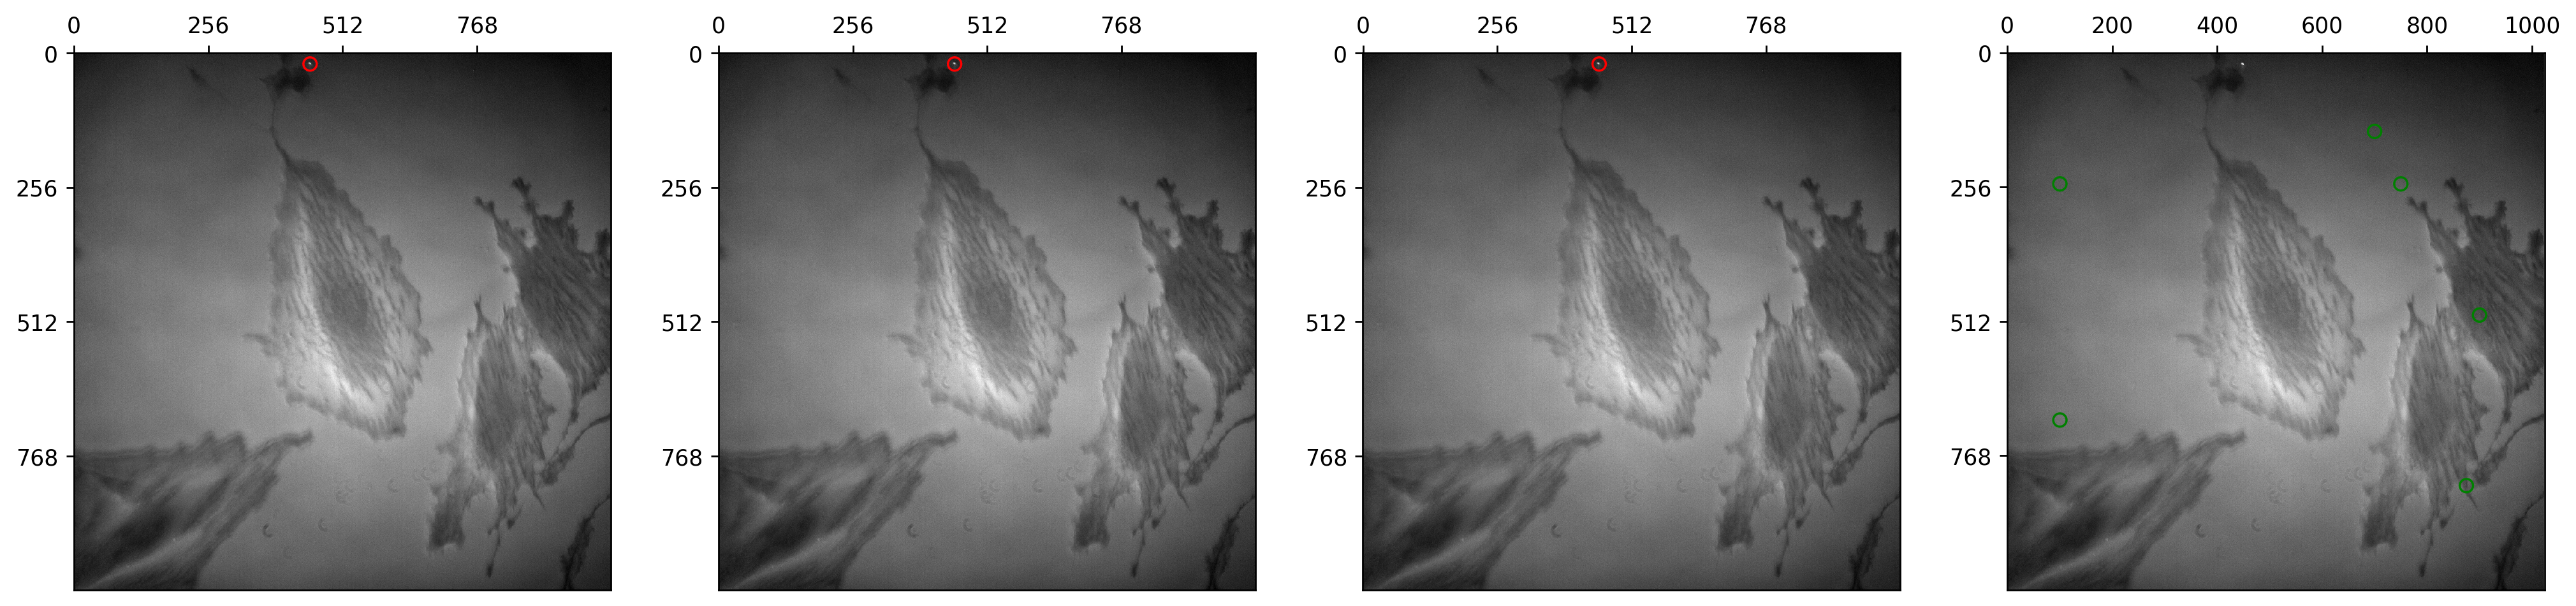

In [18]:
OPTO_cal.apply(core)
affine = dmd.calibrate(verbous = True, blur = 1, circle_size = 7, marker_style = 'o')

### Save current calibration

In [19]:
np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_60x_2bin_CYAN2.npy"), affine)

### Load an old calibration

In [21]:
#affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_CYAN.npy")
#affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM.npy")
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_60x_2bin_CYAN.npy")

In [22]:
affine ## this should print some numbers

array([[-7.69181756e-01, -5.18840982e-03,  8.90947750e+02],
       [-7.32749106e-03,  7.75667268e-01, -1.16885543e+01]])

In [23]:
affine
print(OPTO_cal)

In [24]:
#dmd = dmd(core) #init dmd device

In [25]:
dmd.all_off()

## Preview the channel settings (takes image where stage is now)
These images will then be used later on so you can preview the segmentation. so best take an image of an actual cell!

<Figure size 3000x1500 with 0 Axes>

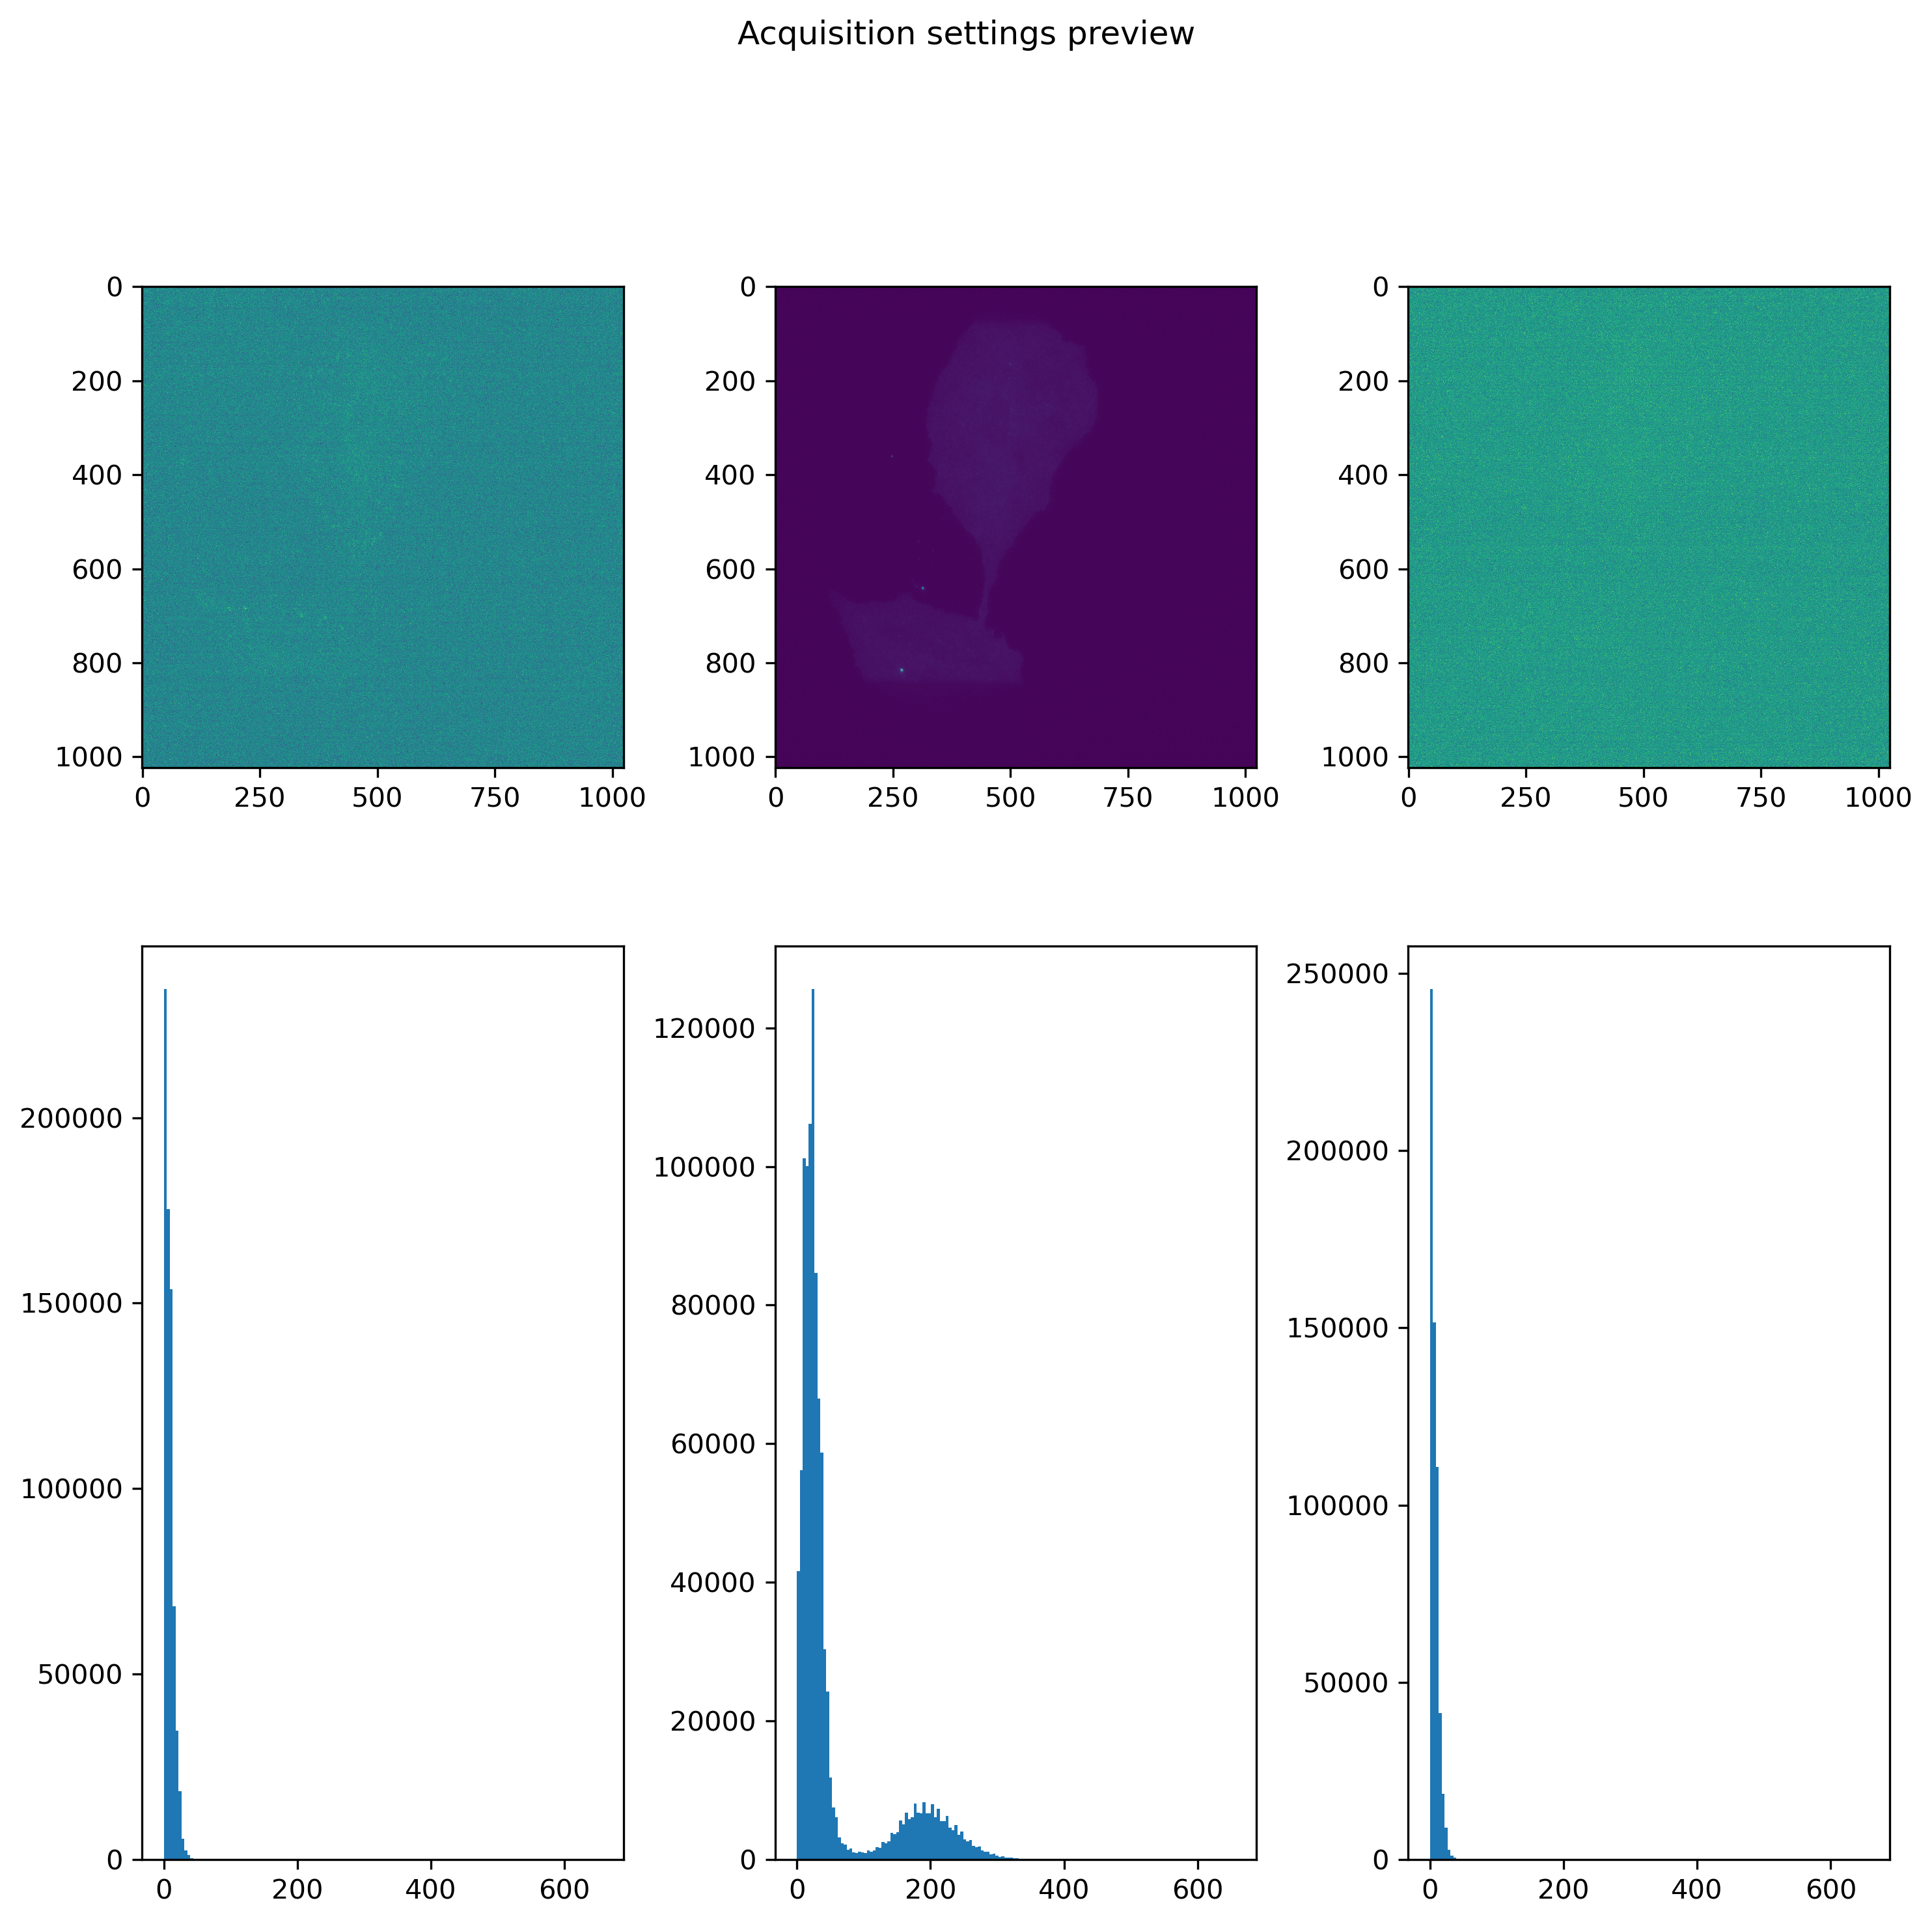

In [26]:
channels_to_acq = [H2B_capture, ERK_capture, OPTO_capture]#OPTO_stim  , OPTO_cal OPTO_capture
frame = acq_multi(channels_to_acq,dmd)
plt.figure(figsize = (10,5),dpi = 300)
fig, axs = plt.subplots(2, len(channels_to_acq), figsize = (10,10),dpi = 300)
fig.suptitle('Acquisition settings preview')
dark_frame = acq_multi_dark(channels_to_acq,dmd)
frame = frame + dark_frame*-1
for channel_nb, channel in enumerate(channels_to_acq):
    axs[0][channel_nb].imshow(frame[channel_nb,:,:])
    axs[0][channel_nb] = channel.name
for channel_nb, channel in enumerate(channels_to_acq):
    flat = frame[channel_nb,:,:].flatten()
    axs[1][channel_nb].hist(flat, bins=150, range=(0, 65535/100))
plt.tight_layout()
plt.show()

## Train the pixel clf (only needed if you use the pixel classifier instead of the thresholding)

save classifier 

In [34]:
file = open("F:\\Max\\micromanager\\calibration\\classifier_max_2021-10-15_DLC1.pkl", "wb")
pkl.dump(clf, file)

file.close()

load classifier

In [27]:
file = open("F:\\Max\\micromanager\\calibration\\classifier_max_2021-10-15_DLC1.pkl", "rb")
clf = pkl.load(file)
file.close()

preprocessing and settings for classifier (run before training)

In [52]:
## Load old image instead of runnning on live data
project_path = 'Z:\\lhinder\\data\\rtm_mm_data\\exp_63\\'
fov = 0
file_name_pattern = str(fov).zfill(2)+"_*.tiff"

print(file_name_pattern)
filenames = sorted(glob.glob(project_path + os.path.join("raw",file_name_pattern)))
print(filenames[-1])
raw = io.imread(filenames[-1])
frame = raw

00_*.tiff
Z:\lhinder\data\rtm_mm_data\exp_63\raw\00_00099.tiff


In [28]:
norm_min = 5
norm_max = 95
f_h2b = frame[1,:,:].copy()
annotation_frame = normalize(f_h2b, norm_min,norm_max)

In [29]:
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)

train classifier

In [61]:
#create the classifier
clf = RandomForestClassifier(random_state=0)

# create feature extractor and apply 
#shapes = [(1024,1024),(512,512),(256,256),(128,128),(64,64)]
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(annotation_frame,models,shapes)


@magicgui(call_button='train classifier')
def clf_widget():
    #run everytime the train button is pressed
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, annotation_frame.shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def annotations_to_tensor(feature_matrix,mask):
    #feature matrix dim: [x,y,nb_features]
    #possible mask elements: 0: not annotated, int[1,2]: class annotation
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        X_features.append(feature_matrix[x,y,:])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

viewer = napari.view_image(annotation_frame, name="My Image")


labels_layer = viewer.add_labels(np.zeros_like(annotation_frame).astype(int), seed = 0)
viewer.window.add_dock_widget(clf_widget)
prediction_layer = viewer.add_image(np.zeros_like(annotation_frame),colormap='PiYG')
prediction_layer.visible = False
prediction_layer.name = "Classifier prediction"
napari.run()

# KOBUS DECIDE HERE: Segmentation using pixel classsifier or segmentation using simple thresholding

The cell you executed last will be used in the experiment


Run the cell below for using the pixel classifier:

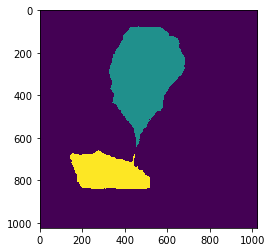

In [30]:
#### Old way with pixel classifier
def frame_to_labels(frame):
    f_h2b = frame[1,:,:].copy()
    f_h2b_scaled = normalize(f_h2b, 5,95)
    features = fd_VGG16_pyramid(f_h2b_scaled,models,shapes)
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, f_h2b_scaled.shape)
    

    #now run watershed on segmentaion, using no seed
    prediction_img = prediction_img>0.5
    prediction_img = skimage.morphology.erosion(prediction_img, square(5))
    prediction_img = skimage.morphology.remove_small_objects(prediction_img, min_size = 100**2)
    prediction_img = scipy.ndimage.morphology.binary_fill_holes(prediction_img)
    
    
    
    #labels = skimage.segmentation.watershed(-distance_img, mask = prediction_img)#, mask=prediction_img>0.5)
    labels = skimage.segmentation.watershed(~prediction_img, mask = prediction_img)

    return labels

labels = frame_to_labels(frame)
plt.imshow(labels%21)

Run the cell below to use the thresholding method:

(skip to the end of the notebook to see how this method performed on the last experiment)

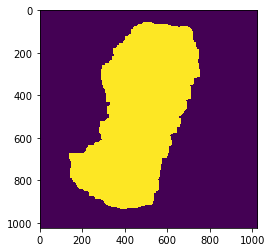

In [103]:
#### Super simplified way using thresholding 
def frame_to_labels(frame):
    threshold = 25 ### SET THE THRESHOLD HERE
            ## check the histogram in the preview to see what the intensity of the background is
            ## most likely 150 will work fine in next experiment as well
    
    mask = frame[1,:,:]>threshold ##select here the channel you want to segment on
    mask = skimage.morphology.remove_small_objects(mask,50)
    mask = skimage.morphology.remove_small_holes(mask, area_threshold=2000, connectivity=1)
    mask = skimage.morphology.opening(mask,np.ones((25,25)))
    labels = skimage.segmentation.watershed(~mask, mask = mask)
    labels = skimage.morphology.remove_small_objects(labels, min_size = 100**2)
    return labels
models = []
labels = frame_to_labels(frame)
plt.imshow(labels%21)

#### From here on notebook continues as before

### Preview the spot drawing logic of the experiment on the last image taken

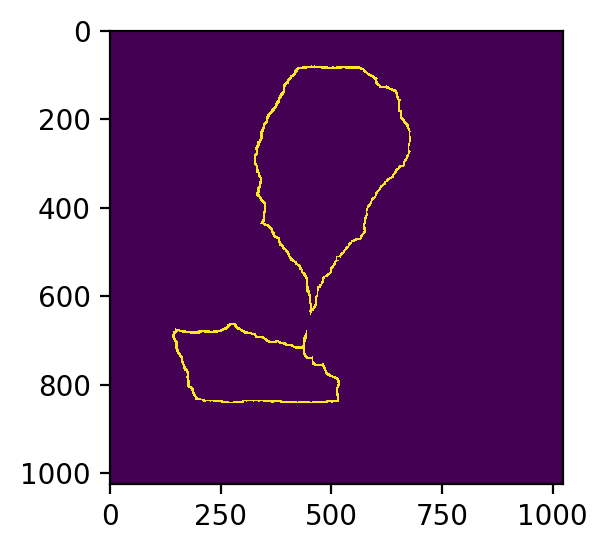

In [31]:
light_mask_combined,DF = spot_mask_from_labels(labels)
plt.figure(figsize=(3,3),dpi = 200)
plt.imshow(light_mask_combined)
plt.show()

## Pipeline functions for segementation and acquisition (just run, nothing to change)

In [32]:
'''
Run segmentation and tracking on a single frame.
Input:
    raw_image[t], tracks[:t-1], treatment_type

Output:
    labeled_image[t], tracks[t], (stim_image[t])
'''
import time
from skimage import io
import numpy as np
import pandas as pd
import time
import trackpy as tp
from csbdeep.utils import Path, normalize
from skimage.measure import regionprops_table
from skimage.morphology import remove_small_objects
import pandas as pd
from pipeline.stimulation import stim_random,stim_clever, stim_cnn, apo_random, continuous_apo, move_up,move_down, move_control
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt


def wait_function(fov, time_between_frames,experiment_start_time):
    #check the time since the last exposure
    #wait if its less than the temporal resolution we aim for

    current_time = time.time()-experiment_start_time #relative time scince start of experiment

    if fov.last_frame_time != None: #not the first frame 
        #check if we need to wait
        time_scince_last_frame = current_time - fov.last_frame_time
        wait_time = time_between_frames-time_scince_last_frame
        if time_scince_last_frame > time_between_frames:
            # we're to slow.
            seconds_behind = (wait_time)*-1
            if seconds_behind > 5: # Hardware cannot keep up!
                print('Seconds behind: ' + str(round(seconds_behind,2)))
                print('Warning: Use less FOVs, set framerate cannot be achieved.') 
        else:
            # we're to fast. Wait the remaining time.
            print('Wait some time: ' + str(round(wait_time, 2)))
            time.sleep(wait_time)

    fov.last_frame_time = current_time
    return


def extract_ring(labels, margin = 2, distance = 10):#distance = 10 for 40x; 4px for 20x
    '''Create the cytosolic rings.
    Args:
        margin: nb pixels between nucleus and ring
        distance: nb pixels ring width (margin is subtracted)
    '''
    labels_expanded_margin  = expand_labels(labels, distance=margin)
    labels_expanded_rings = expand_labels(labels, distance=distance)
    labels_expanded_rings[labels_expanded_margin!=0] = 0
        
    return labels_expanded_rings.astype(int)


def extract_features(labels,raw):
    '''Create a table with features for every detected cell.
    Args:
        labels: frame with labeled nuclei
        raw: raw frame with dimensions [x,y,c]
        details: additional info from stardist (e.g. centroids)
    '''
    raw = np.moveaxis(raw,0,2) #CXY to XYC
    labels_ring = extract_ring(labels) #create cytosolic rings
    #EXTRACT FEATURES
    table_nuc = regionprops_table(labels, raw, ["mean_intensity","label","centroid"]) #extract features#"centroid"
    table_ring = regionprops_table(labels_ring, raw, ["mean_intensity","label"])

    #CREATE TABLES
    table_nuc = pd.DataFrame.from_dict(table_nuc)
    table_ring = pd.DataFrame.from_dict(table_ring)
    table_nuc =  table_nuc. rename({'mean_intensity-0': 'mean_intensity_C0_nuc',  'mean_intensity-1': 'mean_intensity_C1_nuc',  'mean_intensity-2': 'mean_intensity_C2_nuc'},  axis='columns')
    table_ring = table_ring.rename({'mean_intensity-0': 'mean_intensity_C0_ring', 'mean_intensity-1': 'mean_intensity_C1_ring', 'mean_intensity-2': 'mean_intensity_C2_ring'}, axis='columns')
    
    #CONCAT TABLES
    table = table_nuc.merge(table_ring,  on=["label"])

    #CALCULATE the ERK ratio
    table['ratio_ERK'] = table['mean_intensity_C1_ring']/table['mean_intensity_C1_nuc']

    # add the points from stardist TODO
    #table['x'] = details["points"][:,0]
    #table['y'] = details["points"][:,1]
    # need to match points by label, as sometimes nb cells can differ between label mask and detected nuclei.
    # this is very rare and hard to catch:
    # ValueError: Length of values (291) does not match length of index (290)
    # temporarily use centroids from label map region props.
    table = table.rename({'centroid-0': 'x', 'centroid-1': 'y'}, axis='columns')
    return table, labels_ring


def add_frame(frame, fov, clf_models,time_point, stim_frame, output_path, norm_min, norm_max):
    time_start = time.time()

    #name under which the images are stored
    fname = f'{str(fov.index).zfill(2)}_{str(time_point).zfill(5)}'
    
    ### Extract the labels using the trained pixel classifier
    labels = frame_to_labels(frame)
    
    ## FEATURE EXTRACTION ##    
    table_new,labels_rings = extract_features(labels,frame)

    table_new['frame']=time_point
    table_new['stim']=False
    table_new['time']=fov.last_frame_time #relative time scince beginning of experiment

    ## COMBINE TABLES ##
    #get the previous tracks frame
    table_old = fov.tracks

    print(f'FOV {fov.index} type of old tracks: {type(fov.tracks)}.')
    coordinates = np.array(table_new[['x','y']]) #Convert the df to an array of shape (shape: N, ndim) for trackpy

    if time_point == 0: # or table_old == None
        #this is the first frame
        fov.linker.init_level(coordinates, time_point) #extract positions and convert to horizontal list
        table_new['particle'] = fov.linker.particle_ids
        table_tracked = table_new

    else:
        #this is not the first frame
        if len(table_new.index) != 0:
            fov.linker.next_level(coordinates, time_point) #extract positions and convert to horizontal list
            table_new['particle'] = fov.linker.particle_ids
        table_tracked = pd.concat([table_old,table_new])

    #this is against a in trackpy, where the same ID gets assigned twice in one frame
    table_tracked = table_tracked.drop_duplicates(subset=['particle','frame']) 

    #light_mask = create_light_mask(labels,direction)
    #light_mask = light_mask.astype(np.uint8)

    labels_stim = table_tracked[table_tracked['frame']==time_point]['label'].values
    # fov.light_mask_queue.put(light_mask)  #quickly out the light mask into the queue so we can start the stimulation

    #write in table which labels are stimulated
    table_tracked = table_tracked.reset_index(drop=True)
    stim_index = np.where((table_tracked['frame']==time_point) & (table_tracked['label'].isin(labels_stim)))[0]
    table_tracked.loc[stim_index,'stim']=stim_frame

    time_stop = time.time()
    print(f'Time to process one frame: {(time_stop-time_start):0.2f} seconds. Found {len(table_new.index)} cells. Frame {time_point}, FOV {fov.index}.') 

    io.imsave(output_path+'raw\\'+fname+'.tiff',frame, check_contrast=False)
    io.imsave(output_path+'mask\\'+fname+'.tiff',labels, check_contrast=False)
    table_tracked.to_pickle(output_path+'tracks\\'+fname+'.pkl')
    return table_tracked, labels



### Create FOV objects from the positions (just run, nothing to change)

In [33]:
search_range = 15
memory = 5

fovs = []
for pos_nb, pos in enumerate(position_list):
    treatment = "four_spots"
    fov = FOV(core, pos, treatment, pos_nb,  search_range, memory)
    fovs.append(fov)

### Set up acquisition parameters (change stuff here)

In [34]:
### Settings for pipeline REAL MODE ###
test_mode = False   #leave this
time_between_frames = 15 ## HOW MANY SECONDS IN BETWEEN FRAMES?
nb_time_steps = 60       ## HOW MANY FRAMES IN TOTAL PER FOV? change here
norm_min = 5        #leave this
norm_max = 95       #leave this
table_old = None    #leave this
stim_frame = False  #leave this
search_range = 15   #leave this
memory = 3          #leave this
np.random.seed(6)   #leave this
lbl_cmap = random_label_cmap() #leave this 
output_path = 'F:\\Max\\STAR\\STAR_44\\1B2_2\\' #CHANGE HERE

## Create the required folders 
required_folders = ['light_mask','raw','mask','stim','tracks','opto_check','spot_table'] #leave this
create_folders(output_path,required_folders)  #leave this

Directory F:\Max\STAR\STAR_44\1B2_2\light_mask created 
Directory F:\Max\STAR\STAR_44\1B2_2\raw created 
Directory F:\Max\STAR\STAR_44\1B2_2\mask created 
Directory F:\Max\STAR\STAR_44\1B2_2\stim created 
Directory F:\Max\STAR\STAR_44\1B2_2\tracks created 
Directory F:\Max\STAR\STAR_44\1B2_2\opto_check created 
Directory F:\Max\STAR\STAR_44\1B2_2\spot_table created 


### Start acquisition! (change stuff here)

In [35]:
time_start = time.time()

for fov in fovs[:]:
    #move to new FOV
    fov.move_stage_to_fov()
    presets = [H2B_capture,ERK_capture]
    dark_frame = acq_multi_dark(presets,dmd)
    experiment_start_time = time.time()
    
    df_spots = pd.DataFrame()
    
    for time_step in range(nb_time_steps):
        fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'

        
        #check the time, wait to keep the time resolution
        wait_function(fov,time_between_frames,experiment_start_time)
        
        presets = [H2B_capture,ERK_capture]
        frame = acq_multi(presets,dmd)
        #Remove background
        frame = frame + dark_frame*-1
        
        
        stim_frame= False
        
        ### CHANGE HERE ####
        ### AFTER HOW MANY FRAMES SHOULD STIM BEGIN
        stimlist=[60, 61]
        if (time_step >= 18 and time_step < 30): #or (time_step in stimlist):
        #    if (time_step % 3) ==0:
            stim_frame= True

# for multiple stimulations in single experiment
#        if (time_step >= 20 and time_step < 30):
#            stim_frame= True
#        if (time_step >= 40 and time_step < 50):
#            stim_frame= True
#        if (time_step >= 60 and time_step < 70):
#            stim_frame= True
        
        
        #Take an image

        tracks, labels = add_frame(frame, fov, models,time_step, stim_frame, output_path, norm_min, norm_max)
        fov.tracks = tracks

        if time_step == 0:
            # Create stim frame
            spot_mask,df_spot = spot_mask_from_labels(labels)
            df_spot['fov']=fov.index
            df_spot['time_step']=time_step
            df_spot.to_csv(output_path+'spot_table\\'+fname+'.csv')
            df_spots = df_spots.append(df_spot)

        if stim_frame:
            stim_img = acq_stim(spot_mask,OPTO_cal,affine,dmd)        

            io.imsave(output_path+'stim\\'+fname+'.tiff',stim_img, check_contrast=False)
            io.imsave(output_path+'light_mask\\'+fname+'.tiff',spot_mask, check_contrast=False)
        else:
            # save an empty image so the dimensions match up in napari
            fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
            io.imsave(output_path+'stim\\'+fname+'.tiff',np.zeros((1024,1024)), check_contrast=False)
            io.imsave(output_path+'light_mask\\'+fname+'.tiff',np.zeros((1024,1024)), check_contrast=False)

       # frame = acq_multi(presets,dmd)
        #Remove background
       # frame = frame + dark_frame*-1
        #start the processing
        
        if time_step != 0:
            #If not the first frame, get the processed track df from the thread.
            print(f'FOV {fov.index} track file has {len(fov.tracks.index)} entries.')

        time_stop = time.time()
        processing_time = time_stop - time_start
        
        if  time_step == nb_time_steps-1:
            #last frame, take exposure of opto sensor
            presets = [H2B_capture, ERK_capture, OPTO_capture]
            frame = acq_multi(presets,dmd)
            io.imsave(output_path+'opto_check\\'+fname+'.tiff',frame, check_contrast=False)

    gc.collect()
df_spots.to_csv(output_path+'spot_table\\'+'all_fovs.csv')

FOV 0 type of old tracks: <class 'NoneType'>.
Time to process one frame: 11.99 seconds. Found 1 cells. Frame 0, FOV 0.
Wait some time: 1.36
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.95 seconds. Found 1 cells. Frame 1, FOV 0.
FOV 0 track file has 2 entries.
Wait some time: 0.06
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.94 seconds. Found 1 cells. Frame 2, FOV 0.
FOV 0 track file has 3 entries.
Wait some time: 1.29
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.95 seconds. Found 1 cells. Frame 3, FOV 0.
FOV 0 track file has 4 entries.
Wait some time: 0.13
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.97 seconds. Found 1 cells. Frame 4, FOV 0.
FOV 0 track file has 5 entries.
Wait some time: 1.28
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.9

FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.02 seconds. Found 1 cells. Frame 45, FOV 0.
FOV 0 track file has 46 entries.
Wait some time: 0.61
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.02 seconds. Found 1 cells. Frame 46, FOV 0.
FOV 0 track file has 47 entries.
Wait some time: 0.75
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.02 seconds. Found 1 cells. Frame 47, FOV 0.
FOV 0 track file has 48 entries.
Wait some time: 0.61
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.03 seconds. Found 1 cells. Frame 48, FOV 0.
FOV 0 track file has 49 entries.
Wait some time: 0.73
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.02 seconds. Found 1 cells. Frame 49, FOV 0.
FOV 0 track file has 50 entries.
Wait some time: 0.62
FOV 0 type of old tracks: <class 'p

FOV 1 track file has 30 entries.
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.33 seconds. Found 1 cells. Frame 30, FOV 1.
FOV 1 track file has 31 entries.
Wait some time: 0.49
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.34 seconds. Found 1 cells. Frame 31, FOV 1.
FOV 1 track file has 32 entries.
Wait some time: 0.54
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.34 seconds. Found 1 cells. Frame 32, FOV 1.
FOV 1 track file has 33 entries.
Wait some time: 0.48
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.33 seconds. Found 1 cells. Frame 33, FOV 1.
FOV 1 track file has 34 entries.
Wait some time: 0.55
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.35 seconds. Found 1 cells. Frame 34, FOV 1.
FOV 1 track file has 35 entries.
Wait some time: 0.48
FO

FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.30 seconds. Found 1 cells. Frame 13, FOV 2.
FOV 2 track file has 14 entries.
Wait some time: 0.09
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.30 seconds. Found 1 cells. Frame 14, FOV 2.
FOV 2 track file has 15 entries.
Wait some time: 0.98
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.33 seconds. Found 1 cells. Frame 15, FOV 2.
FOV 2 track file has 16 entries.
Wait some time: 0.06
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.34 seconds. Found 1 cells. Frame 16, FOV 2.
FOV 2 track file has 17 entries.
Wait some time: 0.94
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.31 seconds. Found 1 cells. Frame 17, FOV 2.
FOV 2 track file has 18 entries.
Wait some time: 0.12
FOV 2 type of old tracks: <class 'p

FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.39 seconds. Found 1 cells. Frame 57, FOV 2.
FOV 2 track file has 58 entries.
Wait some time: 0.51
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.35 seconds. Found 1 cells. Frame 58, FOV 2.
FOV 2 track file has 59 entries.
Wait some time: 0.52
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.36 seconds. Found 1 cells. Frame 59, FOV 2.
FOV 2 track file has 60 entries.
FOV 3 type of old tracks: <class 'NoneType'>.
Time to process one frame: 12.03 seconds. Found 2 cells. Frame 0, FOV 3.
Wait some time: 1.31
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.01 seconds. Found 2 cells. Frame 1, FOV 3.
FOV 3 track file has 4 entries.
Wait some time: 0.04
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.03 seconds. Foun

FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.01 seconds. Found 2 cells. Frame 42, FOV 3.
FOV 3 track file has 86 entries.
Wait some time: 1.04
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.02 seconds. Found 2 cells. Frame 43, FOV 3.
FOV 3 track file has 88 entries.
Wait some time: 0.31
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.03 seconds. Found 2 cells. Frame 44, FOV 3.
FOV 3 track file has 90 entries.
Wait some time: 1.03
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.01 seconds. Found 2 cells. Frame 45, FOV 3.
FOV 3 track file has 92 entries.
Wait some time: 0.34
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.04 seconds. Found 2 cells. Frame 46, FOV 3.
FOV 3 track file has 94 entries.
Wait some time: 0.93
FOV 3 type of old tracks: <class 'p

FOV 4 track file has 27 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.15 seconds. Found 1 cells. Frame 27, FOV 4.
FOV 4 track file has 28 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.20 seconds. Found 1 cells. Frame 28, FOV 4.
FOV 4 track file has 29 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.17 seconds. Found 1 cells. Frame 29, FOV 4.
FOV 4 track file has 30 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.17 seconds. Found 1 cells. Frame 30, FOV 4.
FOV 4 track file has 31 entries.
Wait some time: 0.64
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.15 seconds. Found 1 cells. Frame 31, FOV 4.
FOV 4 track file has 32 entries.
Wait some time: 0.6
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
T

FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 11, FOV 5.
FOV 5 track file has 12 entries.
Wait some time: 0.09
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 12, FOV 5.
FOV 5 track file has 13 entries.
Wait some time: 1.21
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.11 seconds. Found 1 cells. Frame 13, FOV 5.
FOV 5 track file has 14 entries.
Wait some time: 0.05
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 1 cells. Frame 14, FOV 5.
FOV 5 track file has 15 entries.
Wait some time: 1.22
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.13 seconds. Found 1 cells. Frame 15, FOV 5.
FOV 5 track file has 16 entries.
FOV 5 type of old tracks: <class 'pandas.core.frame.Data

FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.06 seconds. Found 1 cells. Frame 55, FOV 5.
FOV 5 track file has 56 entries.
Wait some time: 0.32
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 56, FOV 5.
FOV 5 track file has 57 entries.
Wait some time: 0.93
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.07 seconds. Found 1 cells. Frame 57, FOV 5.
FOV 5 track file has 58 entries.
Wait some time: 0.37
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.09 seconds. Found 1 cells. Frame 58, FOV 5.
FOV 5 track file has 59 entries.
Wait some time: 0.91
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 59, FOV 5.
FOV 5 track file has 60 entries.
FOV 6 type of old tracks: <class 'NoneType'>.
Time to pr

FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.54 seconds. Found 2 cells. Frame 40, FOV 6.
FOV 6 track file has 82 entries.
Wait some time: 0.46
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.55 seconds. Found 2 cells. Frame 41, FOV 6.
FOV 6 track file has 84 entries.
Wait some time: 0.35
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.54 seconds. Found 2 cells. Frame 42, FOV 6.
FOV 6 track file has 86 entries.
Wait some time: 0.41
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.58 seconds. Found 2 cells. Frame 43, FOV 6.
FOV 6 track file has 88 entries.
Wait some time: 0.38
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.56 seconds. Found 2 cells. Frame 44, FOV 6.
FOV 6 track file has 90 entries.
Wait some time: 0.43
FOV 6 type of old tracks: <class 'p

FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.51 seconds. Found 1 cells. Frame 24, FOV 7.
FOV 7 track file has 25 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.51 seconds. Found 1 cells. Frame 25, FOV 7.
FOV 7 track file has 26 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.51 seconds. Found 1 cells. Frame 26, FOV 7.
FOV 7 track file has 27 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.52 seconds. Found 1 cells. Frame 27, FOV 7.
FOV 7 track file has 28 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.55 seconds. Found 1 cells. Frame 28, FOV 7.
FOV 7 track file has 29 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.52 seconds. Found 1 cells. Frame 29, FOV 7.
F

FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.13 seconds. Found 2 cells. Frame 8, FOV 8.
FOV 8 track file has 18 entries.
Wait some time: 1.06
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 2 cells. Frame 9, FOV 8.
FOV 8 track file has 20 entries.
Wait some time: 0.14
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 2 cells. Frame 10, FOV 8.
FOV 8 track file has 22 entries.
Wait some time: 1.13
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.14 seconds. Found 2 cells. Frame 11, FOV 8.
FOV 8 track file has 24 entries.
Wait some time: 0.05
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.15 seconds. Found 2 cells. Frame 12, FOV 8.
FOV 8 track file has 26 entries.
Wait some time: 1.16
FOV 8 type of old tracks: <class 'pan

FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.12 seconds. Found 2 cells. Frame 52, FOV 8.
FOV 8 track file has 98 entries.
Wait some time: 0.91
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.11 seconds. Found 2 cells. Frame 53, FOV 8.
FOV 8 track file has 100 entries.
Wait some time: 0.36
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 2 cells. Frame 54, FOV 8.
FOV 8 track file has 102 entries.
Wait some time: 0.91
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.12 seconds. Found 2 cells. Frame 55, FOV 8.
FOV 8 track file has 104 entries.
Wait some time: 0.34
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 2 cells. Frame 56, FOV 8.
FOV 8 track file has 106 entries.
Wait some time: 0.93
FOV 8 type of old tracks: <clas

FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.52 seconds. Found 3 cells. Frame 36, FOV 9.
FOV 9 track file has 109 entries.
Wait some time: 0.5
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.51 seconds. Found 3 cells. Frame 37, FOV 9.
FOV 9 track file has 112 entries.
Wait some time: 0.37
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.53 seconds. Found 3 cells. Frame 38, FOV 9.
FOV 9 track file has 115 entries.
Wait some time: 0.46
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.52 seconds. Found 2 cells. Frame 39, FOV 9.
FOV 9 track file has 117 entries.
Wait some time: 0.39
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.54 seconds. Found 3 cells. Frame 40, FOV 9.
FOV 9 track file has 120 entries.
Wait some time: 0.44
FOV 9 type of old tracks: <clas

FOV 10 track file has 19 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.49 seconds. Found 1 cells. Frame 19, FOV 10.
FOV 10 track file has 20 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.45 seconds. Found 1 cells. Frame 20, FOV 10.
FOV 10 track file has 21 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.46 seconds. Found 1 cells. Frame 21, FOV 10.
FOV 10 track file has 22 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.44 seconds. Found 1 cells. Frame 22, FOV 10.
FOV 10 track file has 23 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.46 seconds. Found 1 cells. Frame 23, FOV 10.
FOV 10 track file has 24 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame

FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.30 seconds. Found 2 cells. Frame 3, FOV 11.
FOV 11 track file has 8 entries.
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 2 cells. Frame 4, FOV 11.
FOV 11 track file has 10 entries.
Wait some time: 1.11
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.24 seconds. Found 2 cells. Frame 5, FOV 11.
FOV 11 track file has 12 entries.
Wait some time: 0.02
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 2 cells. Frame 6, FOV 11.
FOV 11 track file has 14 entries.
Wait some time: 1.09
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 2 cells. Frame 7, FOV 11.
FOV 11 track file has 16 entries.
Wait some time: 0.01
FOV 11 type of old tracks: <class 'pandas.core.

FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.31 seconds. Found 2 cells. Frame 47, FOV 11.
FOV 11 track file has 96 entries.
Wait some time: 0.37
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.30 seconds. Found 2 cells. Frame 48, FOV 11.
FOV 11 track file has 98 entries.
Wait some time: 0.71
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.28 seconds. Found 2 cells. Frame 49, FOV 11.
FOV 11 track file has 100 entries.
Wait some time: 0.39
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.27 seconds. Found 2 cells. Frame 50, FOV 11.
FOV 11 track file has 102 entries.
Wait some time: 0.72
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.33 seconds. Found 2 cells. Frame 51, FOV 11.
FOV 11 track file has 104 entries.
Wait some time: 0.33
FOV 11 type of ol

FOV 12 track file has 49 entries.
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.72 seconds. Found 1 cells. Frame 30, FOV 12.
FOV 12 track file has 50 entries.
Wait some time: 1.26
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.70 seconds. Found 1 cells. Frame 31, FOV 12.
FOV 12 track file has 51 entries.
Wait some time: 0.21
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.72 seconds. Found 1 cells. Frame 32, FOV 12.
FOV 12 track file has 52 entries.
Wait some time: 1.45
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.72 seconds. Found 1 cells. Frame 33, FOV 12.
FOV 12 track file has 53 entries.
Wait some time: 0.2
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.74 seconds. Found 1 cells. Frame 34, FOV 12.
FOV 12 track file has 54 entries.
Wait som

FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.17 seconds. Found 2 cells. Frame 12, FOV 13.
FOV 13 track file has 26 entries.
Wait some time: 1.2
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.29 seconds. Found 2 cells. Frame 13, FOV 13.
FOV 13 track file has 28 entries.
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.22 seconds. Found 2 cells. Frame 14, FOV 13.
FOV 13 track file has 30 entries.
Wait some time: 1.16
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.18 seconds. Found 2 cells. Frame 15, FOV 13.
FOV 13 track file has 32 entries.
Wait some time: 0.04
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.24 seconds. Found 2 cells. Frame 16, FOV 13.
FOV 13 track file has 34 entries.
Wait some time: 1.1
FOV 13 type of old tracks: <class 'pandas.c

FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.25 seconds. Found 2 cells. Frame 56, FOV 13.
FOV 13 track file has 114 entries.
Wait some time: 0.44
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.23 seconds. Found 2 cells. Frame 57, FOV 13.
FOV 13 track file has 116 entries.
Wait some time: 0.69
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.24 seconds. Found 2 cells. Frame 58, FOV 13.
FOV 13 track file has 118 entries.
Wait some time: 0.45
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.28 seconds. Found 2 cells. Frame 59, FOV 13.
FOV 13 track file has 120 entries.
FOV 14 type of old tracks: <class 'NoneType'>.
Time to process one frame: 12.09 seconds. Found 2 cells. Frame 0, FOV 14.
Wait some time: 1.15
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame

FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.21 seconds. Found 2 cells. Frame 40, FOV 14.
FOV 14 track file has 82 entries.
Wait some time: 1.01
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.14 seconds. Found 2 cells. Frame 41, FOV 14.
FOV 14 track file has 84 entries.
Wait some time: 0.23
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.19 seconds. Found 2 cells. Frame 42, FOV 14.
FOV 14 track file has 86 entries.
Wait some time: 0.96
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.17 seconds. Found 2 cells. Frame 43, FOV 14.
FOV 14 track file has 88 entries.
Wait some time: 0.25
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.15 seconds. Found 2 cells. Frame 44, FOV 14.
FOV 14 track file has 90 entries.
Wait some time: 0.97
FOV 14 type of old t

FOV 15 track file has 24 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.23 seconds. Found 1 cells. Frame 24, FOV 15.
FOV 15 track file has 25 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.23 seconds. Found 1 cells. Frame 25, FOV 15.
FOV 15 track file has 26 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.25 seconds. Found 1 cells. Frame 26, FOV 15.
FOV 15 track file has 27 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 1 cells. Frame 27, FOV 15.
FOV 15 track file has 28 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.25 seconds. Found 1 cells. Frame 28, FOV 15.
FOV 15 track file has 29 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame

FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.39 seconds. Found 2 cells. Frame 7, FOV 16.
FOV 16 track file has 16 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.22 seconds. Found 2 cells. Frame 8, FOV 16.
FOV 16 track file has 18 entries.
Wait some time: 1.16
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.23 seconds. Found 2 cells. Frame 9, FOV 16.
FOV 16 track file has 20 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 2 cells. Frame 10, FOV 16.
FOV 16 track file has 22 entries.
Wait some time: 1.13
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.28 seconds. Found 2 cells. Frame 11, FOV 16.
FOV 16 track file has 24 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one 

FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.31 seconds. Found 2 cells. Frame 51, FOV 16.
FOV 16 track file has 104 entries.
Wait some time: 0.11
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.56 seconds. Found 2 cells. Frame 52, FOV 16.
FOV 16 track file has 106 entries.
Wait some time: 0.7
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.72 seconds. Found 2 cells. Frame 53, FOV 16.
FOV 16 track file has 108 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.56 seconds. Found 2 cells. Frame 54, FOV 16.
FOV 16 track file has 110 entries.
Wait some time: 0.84
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 2 cells. Frame 55, FOV 16.
FOV 16 track file has 112 entries.
Wait some time: 0.27
FOV 16 type of old tracks: <class 'pa

FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.07 seconds. Found 1 cells. Frame 36, FOV 17.
FOV 17 track file has 37 entries.
Wait some time: 1.13
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 37, FOV 17.
FOV 17 track file has 38 entries.
Wait some time: 0.15
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 1 cells. Frame 38, FOV 17.
FOV 17 track file has 39 entries.
Wait some time: 1.13
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 39, FOV 17.
FOV 17 track file has 40 entries.
Wait some time: 0.13
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.12 seconds. Found 1 cells. Frame 40, FOV 17.
FOV 17 track file has 41 entries.
Wait some time: 1.12
FOV 17 type of old t

FOV 18 track file has 19 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.47 seconds. Found 1 cells. Frame 19, FOV 18.
FOV 18 track file has 20 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.63 seconds. Found 1 cells. Frame 20, FOV 18.
FOV 18 track file has 21 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.49 seconds. Found 1 cells. Frame 21, FOV 18.
FOV 18 track file has 22 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.42 seconds. Found 1 cells. Frame 22, FOV 18.
FOV 18 track file has 23 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.42 seconds. Found 1 cells. Frame 23, FOV 18.
FOV 18 track file has 24 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame

FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.93 seconds. Found 2 cells. Frame 3, FOV 19.
FOV 19 track file has 8 entries.
Wait some time: 0.12
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.89 seconds. Found 2 cells. Frame 4, FOV 19.
FOV 19 track file has 10 entries.
Wait some time: 1.36
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.91 seconds. Found 2 cells. Frame 5, FOV 19.
FOV 19 track file has 12 entries.
Wait some time: 0.1
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.93 seconds. Found 2 cells. Frame 6, FOV 19.
FOV 19 track file has 14 entries.
Wait some time: 1.33
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.90 seconds. Found 2 cells. Frame 7, FOV 19.
FOV 19 track file has 16 entries.
Wait some time: 0.13
FOV 19 type of old tracks: 

FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.92 seconds. Found 2 cells. Frame 46, FOV 19.
FOV 19 track file has 94 entries.
Wait some time: 0.98
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.97 seconds. Found 2 cells. Frame 47, FOV 19.
FOV 19 track file has 96 entries.
Wait some time: 0.42
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.93 seconds. Found 2 cells. Frame 48, FOV 19.
FOV 19 track file has 98 entries.
Wait some time: 1.02
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 11.94 seconds. Found 2 cells. Frame 49, FOV 19.
FOV 19 track file has 100 entries.
Wait some time: 0.41
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.06 seconds. Found 2 cells. Frame 50, FOV 19.
FOV 19 track file has 102 entries.
Wait some time: 0.89
FOV 19 type of old

FOV 20 track file has 30 entries.
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.26 seconds. Found 1 cells. Frame 30, FOV 20.
FOV 20 track file has 31 entries.
Wait some time: 0.57
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.25 seconds. Found 1 cells. Frame 31, FOV 20.
FOV 20 track file has 32 entries.
Wait some time: 0.56
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.27 seconds. Found 1 cells. Frame 32, FOV 20.
FOV 20 track file has 33 entries.
Wait some time: 0.55
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.29 seconds. Found 1 cells. Frame 33, FOV 20.
FOV 20 track file has 34 entries.
Wait some time: 0.54
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.32 seconds. Found 1 cells. Frame 34, FOV 20.
FOV 20 track file has 35 entries.
Wait so

FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.14 seconds. Found 1 cells. Frame 13, FOV 21.
FOV 21 track file has 17 entries.
Wait some time: 0.0
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 14, FOV 21.
FOV 21 track file has 18 entries.
Wait some time: 1.29
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 1 cells. Frame 15, FOV 21.
FOV 21 track file has 19 entries.
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.11 seconds. Found 1 cells. Frame 16, FOV 21.
FOV 21 track file has 20 entries.
Wait some time: 1.27
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.08 seconds. Found 1 cells. Frame 17, FOV 21.
FOV 21 track file has 21 entries.
Wait some time: 0.03
FOV 21 type of old tracks: <class 'pandas.

FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.14 seconds. Found 1 cells. Frame 57, FOV 21.
FOV 21 track file has 61 entries.
Wait some time: 0.45
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.10 seconds. Found 1 cells. Frame 58, FOV 21.
FOV 21 track file has 62 entries.
Wait some time: 0.72
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 12.13 seconds. Found 1 cells. Frame 59, FOV 21.
FOV 21 track file has 63 entries.


In [ ]:
def load_sample_from_fov(path,folder,fov):
    file_name_pattern = str(fov).zfill(2)+"_*.tiff"
    filenames = sorted(glob.glob(path + os.path.join(str(folder),file_name_pattern)))
    #print(file_name_pattern)
    # read the first file to get the shape and dtype
    # ASSUMES THAT ALL FILES SHARE THE SAME SHAPE/TYPE
    sample = io.imread(filenames[0])    
    return sample

input_path = 'Z:\\lhinder\\data\\rtm_mm_data\\exp_63\\' #CHANGE HERE
samples = []
for fov_idx in range(16):#16
    sample = load_sample_from_fov(input_path,'raw',fov_idx)
    mask = frame_to_labels(sample[:,:,:])
    mask = skimage.morphology.remove_small_objects(mask,50)
    mask =skimage.morphology.remove_small_holes(mask, area_threshold=2000, connectivity=1)
    
    
   # plt.imshow(sample[1,:,:])
   # plt.show()
   # plt.imshow(frame_to_labels(sample))
   # plt.show()
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(sample[1,:,:])
    f.add_subplot(1,2, 2)
    plt.imshow(frame_to_labels(sample))
    plt.show()
    
    samples.append(sample[1,:,:])
samples = np.array(samples)

In [ ]:
def load_sample_from_fov(path,folder,fov):
    file_name_pattern = str(fov).zfill(2)+"_*.tiff"
    filenames = sorted(glob.glob(path + os.path.join(str(folder),file_name_pattern)))
    #print(file_name_pattern)
    # read the first file to get the shape and dtype
    # ASSUMES THAT ALL FILES SHARE THE SAME SHAPE/TYPE
    sample = io.imread(filenames[0])    
    return sample

input_path = 'Z:\\lhinder\\data\\rtm_mm_data\\exp_70\\' #CHANGE HERE
samples = []
for fov_idx in range(10):#16
    sample = load_sample_from_fov(input_path,'raw',fov_idx)
    mask = frame_to_labels(sample[:,:,:])
    mask = skimage.morphology.remove_small_objects(mask,50)
    mask =skimage.morphology.remove_small_holes(mask, area_threshold=2000, connectivity=1)
    
    
   # plt.imshow(sample[1,:,:])
   # plt.show()
   # plt.imshow(frame_to_labels(sample))
   # plt.show()
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(sample[1,:,:])
    f.add_subplot(1,2, 2)
    plt.imshow(frame_to_labels(sample))
    plt.show()
    
    samples.append(sample[1,:,:])
samples = np.array(samples)

Error when applying setting. Retry nb. 0.
